# Problem Statement

[Urban Sound Classification](https://datahack.analyticsvidhya.com/contest/practice-problem-urban-sound-classification/): Classify Urban Sound Clips into different classes. This notebook is based on [https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/#comment-143974]

The dataset contains 8732 sound excerpts (<=4s) of urban sounds from 10 classes, namely:

- air conditioner
- car horn
- children playing
- dog bark
- drilling
- engine idling
- gun shot
- jackhammer
- siren
- street music

In [1]:
import os

import numpy as np
import pandas as pd

import librosa
import librosa.display

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
random_state = 42

In [3]:
data_dir = "C:/urban-sound-challenge/"

## Load Audio Files

In [4]:
# let's listen to a sound excerpt from the dataset
import IPython.display as ipd
ipd.Audio(os.path.join(data_dir, 'train/', '2022.wav'))

In [5]:
# Now let's load this audio in our notebook as a numpy array. For this, we will use librosa library in python.
data, sampling_rate = librosa.load(os.path.join(data_dir, 'train/', '2022.wav'))

When we load the data, it gives us two objects; a numpy array of an audio file and the corresponding sampling rate by which it was extracted. Let's to represent this as a waveform (which it originally is)

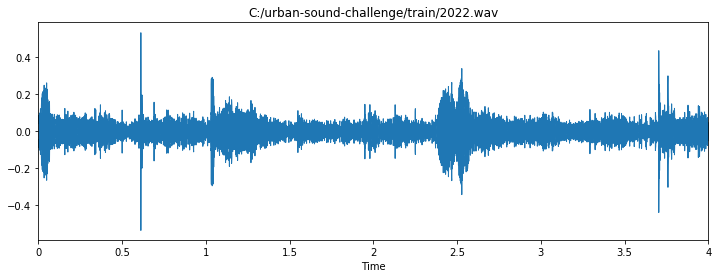

In [6]:
plt.figure(figsize=(12, 4))
plt.title(os.path.join(data_dir, 'train/', '2022.wav'))
librosa.display.waveplot(data, sr=sampling_rate);

In [7]:
# Let's load another audio data
data, sampling_rate = librosa.load(os.path.join(data_dir, 'train/', '33.wav'))

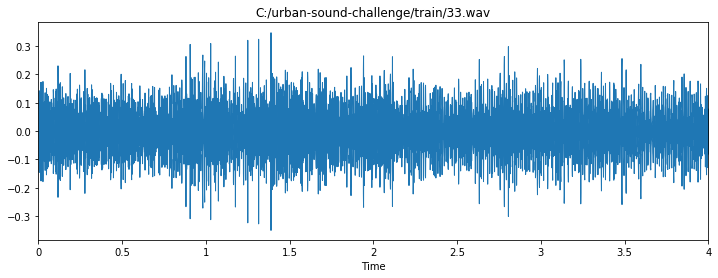

In [8]:
plt.figure(figsize=(12, 4))
plt.title(os.path.join(data_dir, 'train/', '33.wav'))
librosa.display.waveplot(data, sr=sampling_rate);

## Explore the distribution of classes

In [9]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))

In [10]:
train_df.columns

Index(['ID', 'Class'], dtype='object')

In [11]:
train_df['Class'].value_counts()

jackhammer          668
engine_idling       624
siren               607
dog_bark            600
street_music        600
children_playing    600
air_conditioner     600
drilling            600
car_horn            306
gun_shot            230
Name: Class, dtype: int64

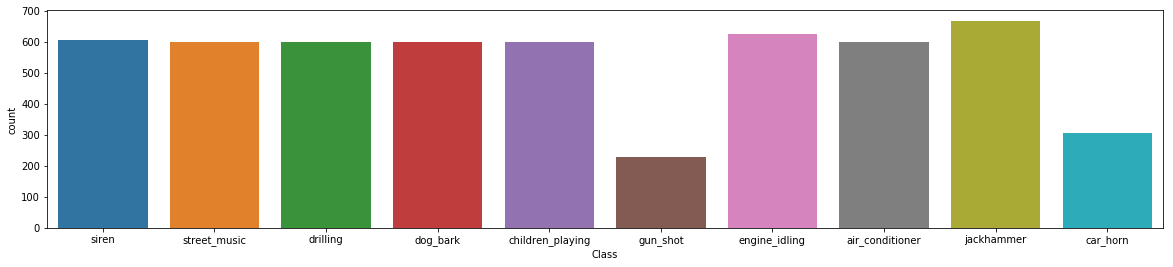

In [12]:
plt.figure(figsize=(20,4))
sns.countplot(x='Class', data=train_df);

### Visually inspect for patterns in our data for different classes

Matplotlib’s specgram method performs all the required calculation and plotting of the spectrum. Likewise, Librosa provide handy method for wave and log power spectrogram plotting.

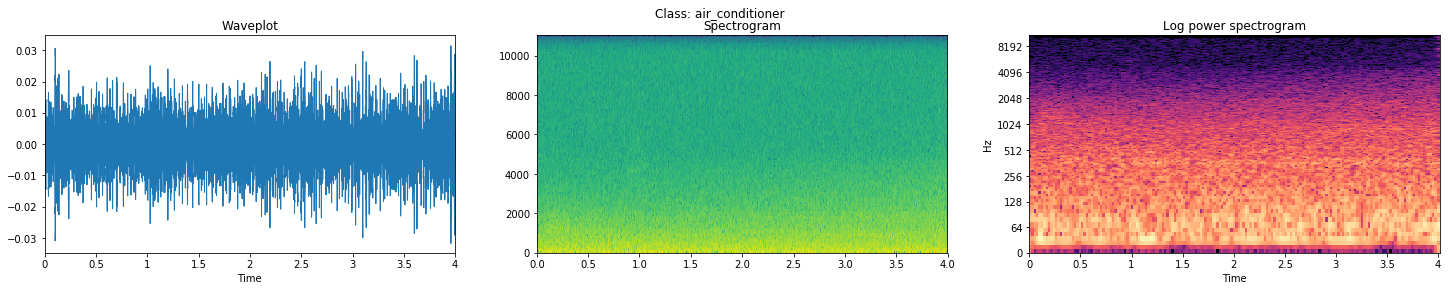

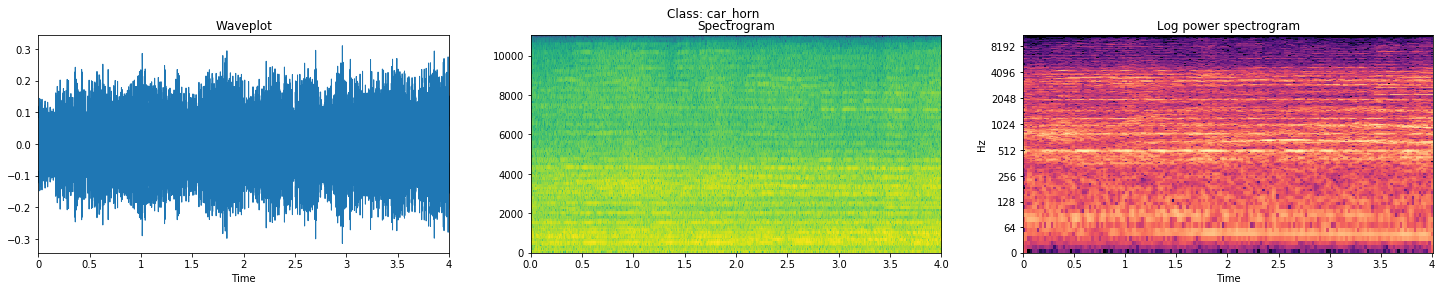

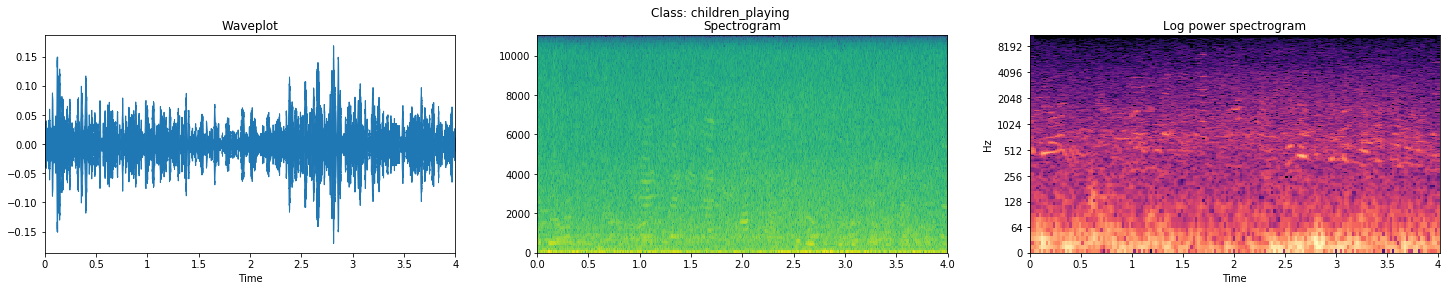

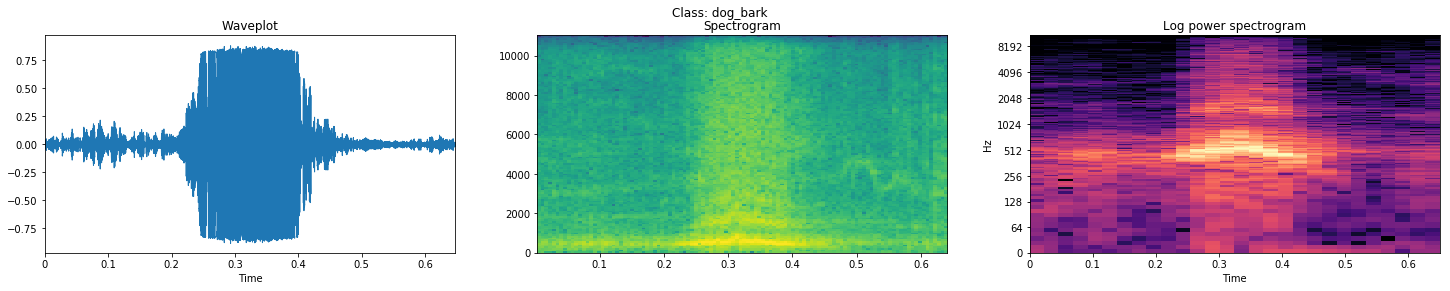

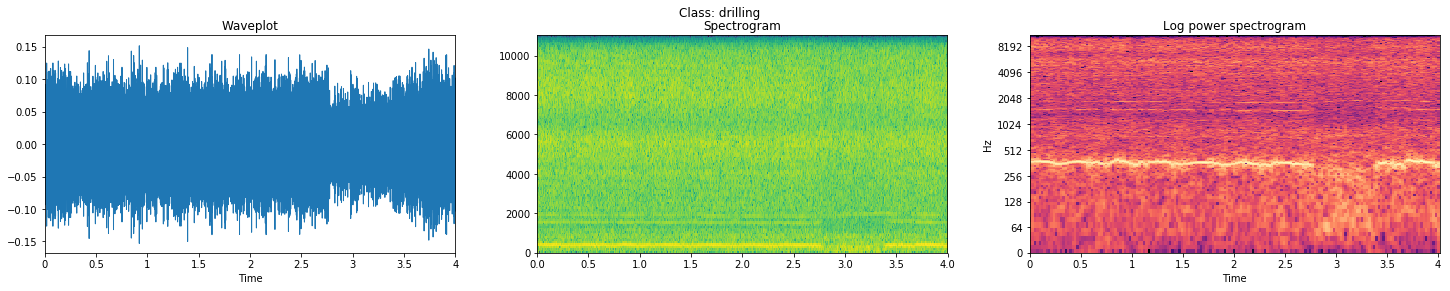

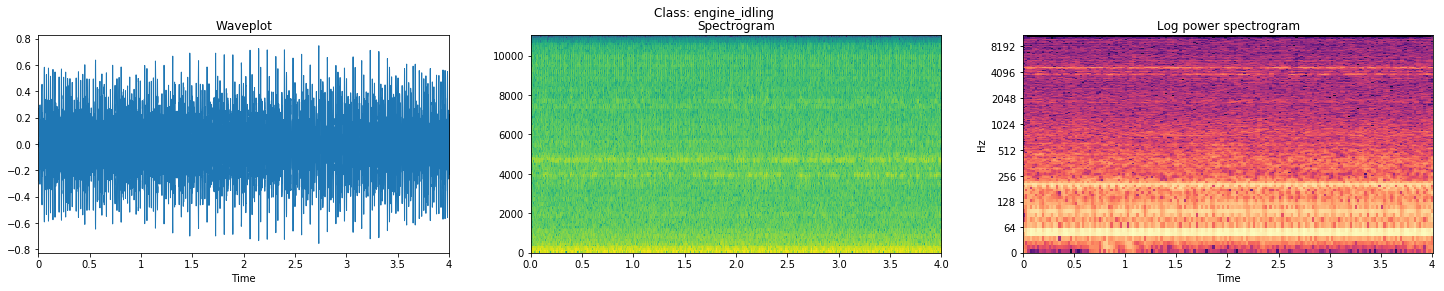

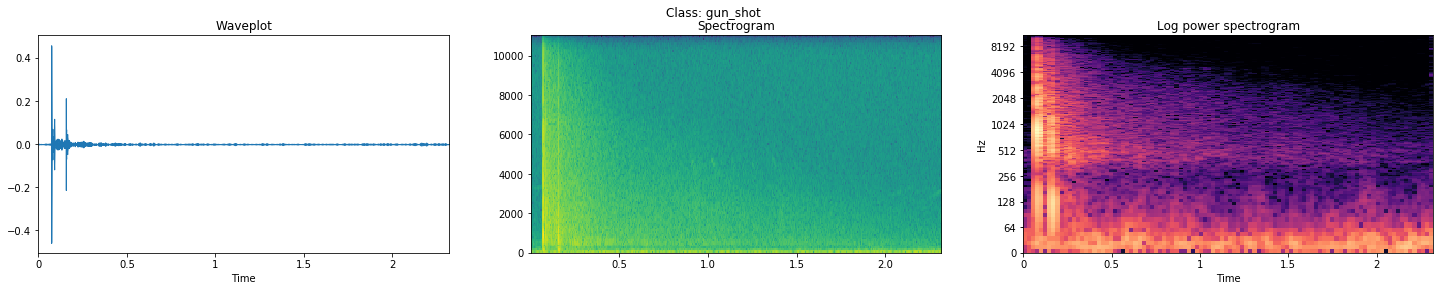

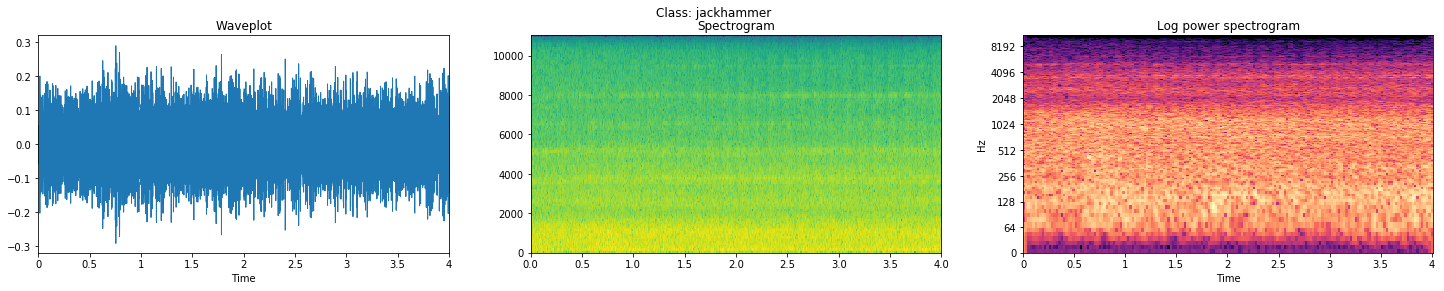

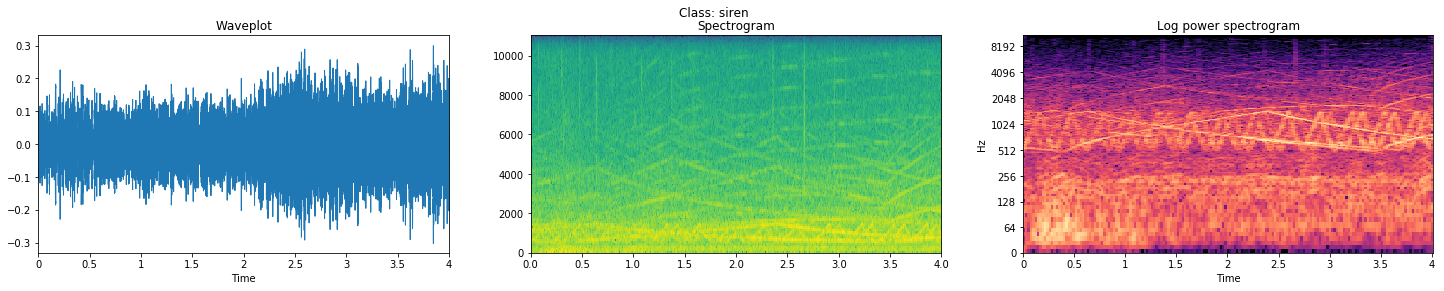

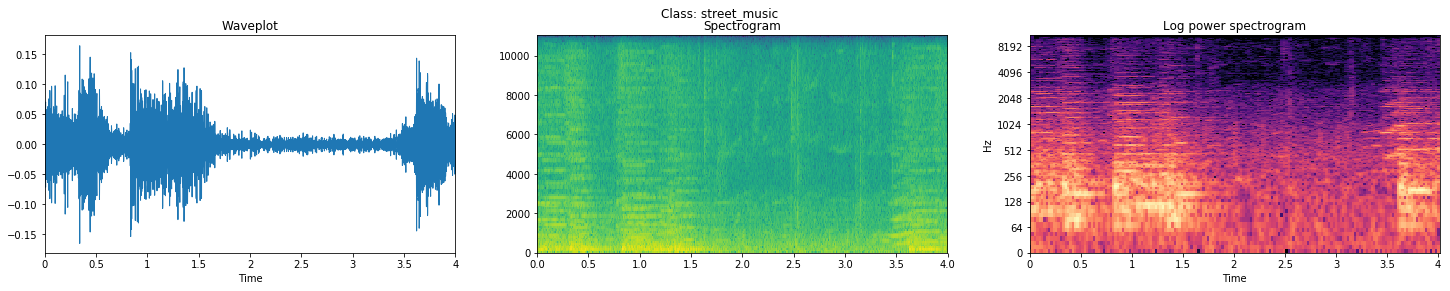

In [13]:
# Choose a random audio file from each 'Class' of audio and plot the wave, spectogram and log spectogram
from matplotlib.pyplot import specgram
for name, group in train_df.groupby(['Class']):
    audio_name = np.random.choice(group['ID'])
    path = os.path.join(data_dir, 'train/', str(audio_name) + '.wav')
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(25, 4))
    plt.subplot(1,3,1)
    librosa.display.waveplot(data, sr=sampling_rate)
    plt.title('Waveplot')
    plt.subplot(1,3,2)
    specgram(data, Fs=sampling_rate)
    plt.title('Spectrogram')
    plt.subplot(1,3,3)
    D = librosa.logamplitude(np.abs(librosa.stft(data))**2, ref_power=np.max)
    librosa.display.specshow(D,x_axis='time' ,y_axis='log')
    plt.title('Log power spectrogram')
    plt.suptitle("Class: {0}".format(name))
    plt.show();

We can see that it may be difficult to differentiate between jackhammer and drilling, but it is still easy to discern between dog_barking and drilling.

## Prepare Data for Machine Learning: Load audio files and extract features

In [14]:
train_df['file_name'] = train_df['ID'].apply(lambda audio_name: os.path.join(data_dir, 'train/', str(audio_name) + '.wav'))
test_df['file_name'] = test_df['ID'].apply(lambda audio_name: os.path.join(data_dir, 'test/', str(audio_name) + '.wav'))

In [15]:
train_df.head(5)

ID         Class                             file_name
0   0         siren  C:/urban-sound-challenge/train/0.wav
1   1  street_music  C:/urban-sound-challenge/train/1.wav
2   2      drilling  C:/urban-sound-challenge/train/2.wav
3   3         siren  C:/urban-sound-challenge/train/3.wav
4   4      dog_bark  C:/urban-sound-challenge/train/4.wav

In [16]:
test_df.head(5)

ID                             file_name
0   5   C:/urban-sound-challenge/test/5.wav
1   7   C:/urban-sound-challenge/test/7.wav
2   8   C:/urban-sound-challenge/test/8.wav
3   9   C:/urban-sound-challenge/test/9.wav
4  13  C:/urban-sound-challenge/test/13.wav

In [17]:
# function to load files and extract features
def feature_extractor(row):
    # handle exception to check if there isn't a file which is corrupted
    try:
        # here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(row.file_name, res_type='kaiser_fast') 
        # we extract mfcc feature from data
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
        # we extract the tempo and beat frames
        tempo, beat_frames = librosa.beat.beat_track(y=X, sr=sample_rate)
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None
 
    feature = np.hstack([mfccs, tempo])
 
    return [feature]

In [18]:
train_feature_df = pd.DataFrame({'feature':train_df.apply(feature_extractor, axis=1), 'label': train_df['Class']})

In [19]:
test_feature_df = pd.DataFrame({'feature':test_df.apply(feature_extractor, axis=1)})

In [20]:
train_feature_df.head()

feature         label
0  [[-82.1149459643, 139.473175813, -42.410085153...         siren
1  [[-15.7698946124, 124.144365738, -29.464481755...  street_music
2  [[-123.380225064, 15.1430984526, -50.069897648...      drilling
3  [[-213.303282869, 89.2718075363, -55.243235657...         siren
4  [[-237.933496285, 135.891856056, 39.2588035713...      dog_bark

In [21]:
test_feature_df.head()

feature
0  [[-76.3032134367, 20.4388702254, -17.567846995...
1  [[-375.738659252, 149.919967815, -21.469241624...
2  [[-150.599516031, -26.280087086, -24.189370765...
3  [[-233.558713852, 99.5196021234, -39.738254696...
4  [[-74.3573559375, 107.861075934, -15.931961447...

In [22]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train, X_test = np.array(train_feature_df.feature.tolist()), np.array(test_feature_df.feature.tolist())
y_train = np.array(train_feature_df.label.tolist())

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))

Using TensorFlow backend.


In [23]:
X_train.shape, y_train.shape, X_test.shape

((5435, 1, 41), (5435, 10), (3297, 1, 41))

In [24]:
X_train = np.squeeze(X_train, axis=1)
X_test = np.squeeze(X_test, axis=1)

In [25]:
X_train.shape, y_train.shape, X_test.shape

((5435, 41), (5435, 10), (3297, 41))

In [26]:
X_train

array([[ -8.21149460e+01,   1.39473176e+02,  -4.24100852e+01, ...,
         -2.60634411e+00,  -1.05348812e+00,   1.07666016e+02],
       [ -1.57698946e+01,   1.24144366e+02,  -2.94644818e+01, ...,
          1.72715475e+00,  -3.39136728e-01,   1.29199219e+02],
       [ -1.23380225e+02,   1.51430985e+01,  -5.00698976e+01, ...,
         -3.98843893e+00,   3.23376594e+00,   1.03359375e+02],
       ..., 
       [ -3.20828370e+02,   5.83127230e+01,  -6.87980146e+00, ...,
         -4.83061128e+00,   2.27465237e+00,   1.29199219e+02],
       [ -2.76953574e+02,   1.41041291e+02,  -3.62527277e+01, ...,
          1.51301273e+00,   1.33335177e+00,   1.43554688e+02],
       [ -2.90978849e+02,   2.33324182e+02,  -4.64877510e+00, ...,
         -3.59747350e-01,  -1.56336742e-02,   1.29199219e+02]])

In [27]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

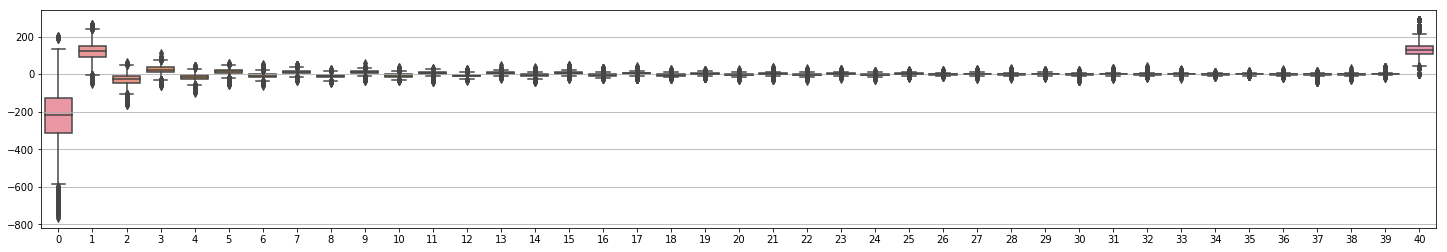

In [28]:
plt.figure(figsize=(25, 4))
plt.grid(which='major')
sns.boxplot(data=pd.DataFrame(X_train));

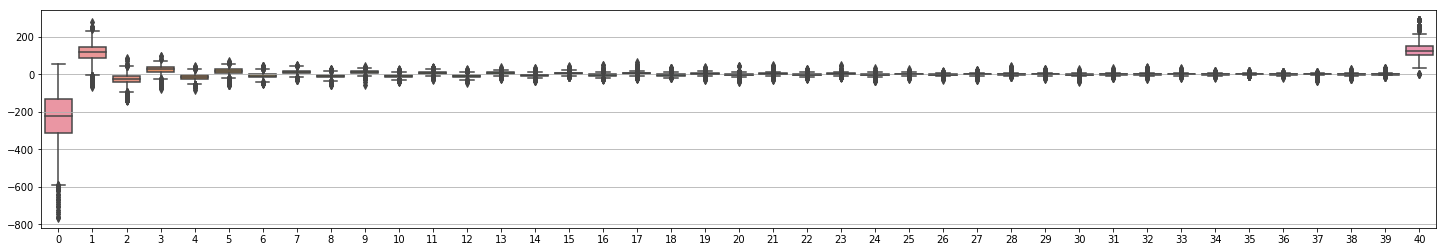

In [29]:
plt.figure(figsize=(25, 4))
plt.grid(which='major')
sns.boxplot(data=pd.DataFrame(X_test));

## Train a Neural Network Model

In [30]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn import metrics 

In [31]:
feature_size = X_train.shape[1]
num_classes = y_train.shape[1]

batch_size = 32
epochs = 50

In [32]:
# a simple neural network
def mlp():
    model = Sequential()

    model.add(Dense(256, input_shape=(feature_size,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [33]:
model = mlp()

In [34]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10752     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
__________

In [36]:
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
tbCallBack = TensorBoard(log_dir='./urban.sound.tb.graph', histogram_freq=0, write_graph=True, write_images=True)

In [37]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=2).historyp

Train on 4076 samples, validate on 1359 samples
Epoch 1/50
 - 0s - loss: 12.8763 - acc: 0.1644 - val_loss: 11.2723 - val_acc: 0.2531
Epoch 2/50
 - 0s - loss: 11.7457 - acc: 0.2431 - val_loss: 11.3534 - val_acc: 0.2649
Epoch 3/50
 - 0s - loss: 11.2700 - acc: 0.2647 - val_loss: 10.2290 - val_acc: 0.3179
Epoch 4/50
 - 0s - loss: 10.5122 - acc: 0.2917 - val_loss: 9.1452 - val_acc: 0.3517
Epoch 5/50
 - 0s - loss: 9.3093 - acc: 0.3234 - val_loss: 5.9603 - val_acc: 0.4474
Epoch 6/50
 - 0s - loss: 4.8678 - acc: 0.3916 - val_loss: 2.2166 - val_acc: 0.5121
Epoch 7/50
 - 0s - loss: 2.4249 - acc: 0.4163 - val_loss: 1.5784 - val_acc: 0.5791
Epoch 8/50
 - 0s - loss: 1.8783 - acc: 0.4563 - val_loss: 1.4037 - val_acc: 0.6122
Epoch 9/50
 - 0s - loss: 1.6829 - acc: 0.4924 - val_loss: 1.3353 - val_acc: 0.6085
Epoch 10/50
 - 0s - loss: 1.5339 - acc: 0.5123 - val_loss: 1.2669 - val_acc: 0.6299
Epoch 11/50
 - 0s - loss: 1.4131 - acc: 0.5451 - val_loss: 1.2153 - val_acc: 0.6336
Epoch 12/50
 - 0s - loss: 1.34

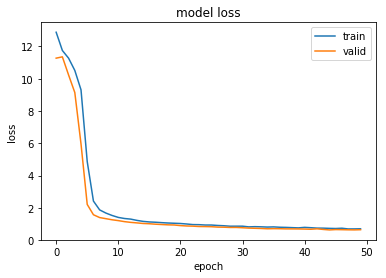

In [38]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.show()

In [39]:
y_pred = model.predict(X_test)

In [40]:
y_pred

array([[  1.11449599e-15,   1.18927834e-09,   1.05733175e-14, ...,
          4.52022059e-10,   1.56734977e-16,   1.86638153e-13],
       [  1.44633651e-02,   1.25131756e-03,   2.65548319e-01, ...,
          9.69011162e-04,   1.50235131e-01,   7.93748647e-02],
       [  1.60960125e-15,   1.46260226e-10,   2.42168230e-11, ...,
          1.69525172e-09,   2.20881695e-16,   9.91650863e-15],
       ..., 
       [  4.07782309e-02,   5.22668893e-03,   5.89099852e-03, ...,
          8.98285449e-01,   8.88221897e-04,   2.78045852e-02],
       [  7.24063693e-06,   2.14358345e-02,   1.99552975e-03, ...,
          8.46899354e-07,   4.44589734e-01,   1.00763282e-03],
       [  2.62005776e-02,   1.70612964e-03,   1.95112731e-02, ...,
          7.09039951e-03,   8.25798333e-01,   1.95026267e-02]], dtype=float32)

In [41]:
lb.classes_

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], 
      dtype='<U16')

In [42]:
test_file_name = test_df.iloc[9]['file_name']
test_file_name

'C:/urban-sound-challenge/test/25.wav'

In [43]:
y_pred[9]

array([  4.48942065e-14,   7.20645810e-09,   1.56125790e-09,
         9.28640147e-05,   3.44443322e-07,   5.14457588e-06,
         8.29035507e-10,   1.17543225e-10,   9.99901652e-01,
         1.64222469e-09], dtype=float32)

In [44]:
lb.classes_[np.argmax(y_pred[9])]

'siren'

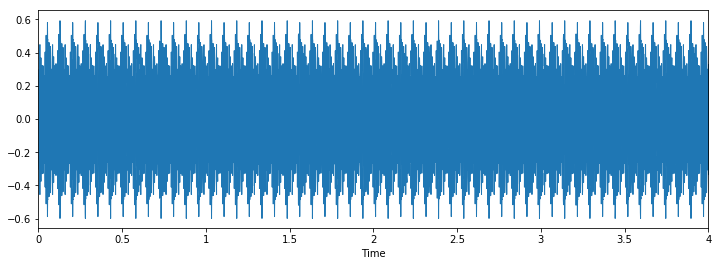

In [45]:
data, sampling_rate = librosa.load(test_file_name)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate);

In [46]:
ipd.Audio(test_file_name)

In [47]:
np.apply_along_axis(np.argmax, 1, y_pred)

array([4, 3, 4, ..., 7, 8, 8], dtype=int64)

In [48]:
y_pred_class = pd.Series(map(lambda x: lb.classes_[x], np.apply_along_axis(np.argmax, 1, y_pred)))
y_pred_class.head(5)

0            drilling
1            dog_bark
2            drilling
3    children_playing
4       engine_idling
dtype: object

In [49]:
test_df.ID.head(5)

0     5
1     7
2     8
3     9
4    13
Name: ID, dtype: int64

In [50]:
submit_df = pd.DataFrame({'Class': y_pred_class, 'ID':test_df.ID})
submit_df.columns = ['Class', 'ID']
submit_df.head(10)

Class  ID
0          drilling   5
1          dog_bark   7
2          drilling   8
3  children_playing   9
4     engine_idling  13
5          drilling  14
6     engine_idling  16
7  children_playing  21
8     engine_idling  23
9             siren  25

In [51]:
submit_df.to_csv(os.path.join(data_dir, "final_submission.csv"), header=True, index=False)